In [24]:
import warnings
warnings.filterwarnings("ignore")

import h5py
import numpy as np
from glob import glob

def datx2py(file_name):
    """Loads a .datx into Python, credit goes to gkaplan.
    https://gist.github.com/g-s-k/ccffb1e84df065a690e554f4b40cfd3a"""
    def _group2dict(obj):
        return {k: _decode_h5(v) for k, v in zip(obj.keys(), obj.values())}
    def _struct2dict(obj):
        names = obj.dtype.names
        return [dict(zip(names, _decode_h5(record))) for record in obj]
    def _decode_h5(obj):
        if isinstance(obj, h5py.Group):
            d = _group2dict(obj)
            if len(obj.attrs):
                d['attrs'] = _decode_h5(obj.attrs)
            return d
        elif isinstance(obj, h5py.AttributeManager):
            return _group2dict(obj)
        elif isinstance(obj, h5py.Dataset):
            d = {'attrs': _decode_h5(obj.attrs)}
            try:
                d['vals'] = obj[()]
            except (OSError, TypeError):
                pass
            return d
        elif isinstance(obj, np.ndarray):
            if np.issubdtype(obj.dtype, np.number) and obj.shape == (1,):
                return obj[0]
            elif obj.dtype == 'object':
                return _decode_h5([_decode_h5(o) for o in obj])
            elif np.issubdtype(obj.dtype, np.void):
                return _decode_h5(_struct2dict(obj))
            else:
                return obj
        elif isinstance(obj, np.void):
            return _decode_h5([_decode_h5(o) for o in obj])
        elif isinstance(obj, bytes):
            return obj.decode()
        elif isinstance(obj, list) or isinstance(obj, tuple):
            if len(obj) == 1:
                return obj[0]
            else:
                return obj
        else:
            return obj
    with h5py.File(file_name, 'r') as f:
        h5data = _decode_h5(f)
    return h5data

def get_data(datx_file):
    """Returns the Surface and Intensity data from a single .datx file"""
    myh5 = datx2py(datx_file)                      # File is the string with the location of the file
    zsurf = myh5['Data']['Surface']           # Get the surfaces
    zdata = list(zsurf.values())[0]           # Good for fixing stuff later  
    zsurf = zdata['vals']                     # Get the data from the surface group
    zsurf[zsurf == zdata['attrs']['No Data']] = np.nan  # Write no data as NaNs for compatibility

    zint = myh5['Data']['Intensity']          # Get the intensity group
    zint = list(zint.values())[0]['vals'].astype(float)  # Get the data from the intensity grou[]
    zint[zint>200000] = np.nan                # This fixes the regions left out from stitching
    return zsurf, zint

def getcleansurf(img):
    trad = np.nanmean(img, axis=0)
    suma = np.nansum(img, axis=0)
    counts = np.sum(~np.isnan(img), axis=0)
    counts[counts<40] = 0
    f = suma/counts
    f[np.isinf(f)] = np.nan
    return f

def find_edge(y, v):
    g2 = np.abs(np.gradient(y))
    #g2 = np.abs(np.gradient(g))
    idx = np.argwhere(g2>v)
    l = idx[0][0]
    h = idx[-1][0]
    #l = np.argmax(g2[:int(len(g2)/2)])
    #h = np.argmax(g2[int(len(g2)/2):])+int(len(g2)/2)
    return l,h

def straightline(x, a, b):
    return a*x + b

def subline(f, offx, offy):
    xchange = -len(f)
    ychange = (f[0]-offx)-(f[-1]-offy)
    xarray = np.arange(len(f))
    yarray = straightline(xarray, ychange/xchange, (f[0]-offx))
    res = (f-yarray)
    return res

In [9]:
files = glob("/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-11-09_bgt127dist/*.datx")
files.sort()
offsets = np.zeros([len(files), 2])
C = np.zeros([len(files), 2])
C = np.load('/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-11-09_bgt127dist/bounds.npy').astype(int)

In [10]:
data = []
for i in range(len(files)):
    y = getcleansurf(get_data(files[i])[0])
    y = subline(y[C[i,0]:C[i,1]], 0, 0)
    data.append(y)

/tmp/ipykernel_10536/1063730037.py:66: RuntimeWarning: Mean of empty slice
  trad = np.nanmean(img, axis=0)
/tmp/ipykernel_10536/1063730037.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_10536/1063730037.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


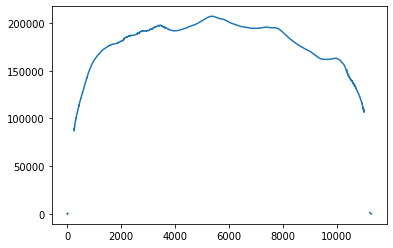

In [12]:
import matplotlib.pyplot as plt

plt.plot(data[0])

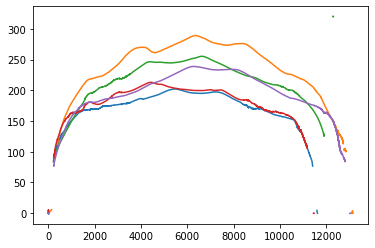

In [50]:
i = 42
offsets[44,1] = 320
for i in range(i, i+5):
    y = getcleansurf(get_data(files[i])[0])/1000
    y = subline(y[C[i,0]:C[i,1]], offsets[i,0], offsets[i,1])
    plt.plot(y)
#plt.ylim(0, 300)

In [51]:
np.save('/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-11-09_bgt127dist/offsets.npy', offsets)

In [53]:
data = []
for n in range(C.shape[0]):
    print(n)
    profile = subline(getcleansurf(get_data(files[n])[0])[C[n,0]:C[n,1]]/1e3, offsets[n,0], offsets[n,1])
    data.append(profile)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [54]:
S = np.array([len(x) for x in data])
np.max(S)

13151

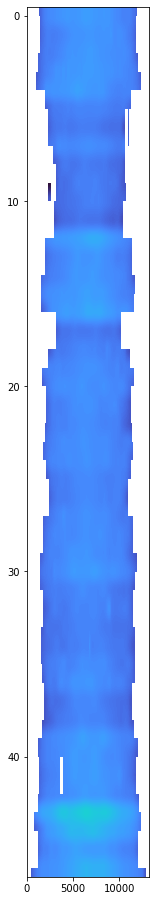

In [55]:
L = 13200
IMG = np.zeros([len(data), L])
IMG[:] = np.nan

start = (L-S)/2
start = start.astype(int)
for i in range(len(data)):
    IMG[i, start[i]:len(data[i])+start[i]] = data[i]
plt.figure(figsize=(16, 16))
plt.imshow(IMG,aspect=2000, cmap="turbo", clim=(0, 3))
np.save('/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-11-09_bgt127dist/profiles.npy', IMG)

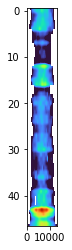

In [59]:
plt.imshow(IMG,aspect=2000, cmap="turbo", clim=(150, 300))


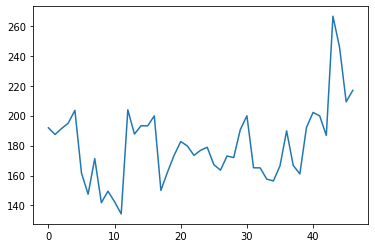

In [63]:
plt.plot(IMG[:,5000])